In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from HelperFunctions import *
from PtOccupancyFunctions import *
import scipy.integrate
import pprint
from FindDataFunctions import *

In [3]:
path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryOrigDestUniformSeed12/"

In [4]:
uni_dirs = getDirs(path, ["reqs", "dist","frac_comm_orig_dest","drt","unimodal"], [None, None, None, None, None])
display(uni_dirs)

[[10000.0,
  3000.0,
  0.6,
  150.0,
  {'root': '/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryOrigDestUniformSeed12/10000reqs/3000dist/0.6frac_comm_orig_dest/150drt/unimodal',
   'persons': '/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryOrigDestUniformSeed12/10000reqs/3000dist/0.6frac_comm_orig_dest/150drt/unimodal/output_persons.csv.gz',
   'ph_modestats': '/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryOrigDestUniformSeed12/10000reqs/3000dist/0.6frac_comm_orig_dest/150drt/unimodal/ph_modestats.txt',
   'pkm_modestats': '/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryOrigDestUniformSeed12/10000reqs/3000dist/0.6frac_comm_orig_dest/150drt/unimodal/pkm_modestats.txt',
   'trip_success': '/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryOrigDestUniformSeed12/10000reqs/3000dist/0.6frac_comm_orig_dest/150drt/unimodal/trip_success.cs

In [5]:
saved_path = os.path.join(path, "saved.pkl")
if os.path.isfile(saved_path):
    df = pd.read_pickle(saved_path)
else:
    cols = ["reqs", "mean_dist","comm_orig_dest_frac", "drt", "occupancy", "occupancy_non_idling", "detour",
            "servability", "req_mean_dist", "drt_wait_time","drt_wait_time_normalized",
            "drt_travel_time_normalized", "drt_distance", "cummulative_dist_drt",
            "cummulative_dist_drt_unshared", "pkm_drt", "idling_frac"]
    
    df = pd.DataFrame(np.full((len(uni_dirs),len(cols)), np.nan), columns=cols)

    for i,entry in enumerate(uni_dirs):
        print(*entry[:-1])
        dic = entry[-1]
        row = df.iloc[i]
#         try:
        row.loc["reqs"] = entry[0]
        row.loc["mean_dist"] = entry[1]
        row.loc["comm_orig_dest_frac"] = entry[2]
        row.loc["drt"] = entry[3]
        row.loc["occupancy"], _ = getDrtOccupandyAndStandingFrac(dic, False, True)
        row.loc["occupancy_non_idling"], row.loc["idling_frac"] = getDrtOccupandyAndStandingFrac(dic, False, False)
        df_detour = getDrtDetours(dic)
        row.loc["detour"] = df_detour["distanceDetour"].mean()
        trip_succ = getTripSuccess(dic)
        row.loc["servability"] = len(trip_succ[trip_succ["tripSuccess"]]) / len(trip_succ)
        df_persons = getPersons(dic)
        row.loc["req_mean_dist"] = df_persons["mean_dist"].mean()
        drt_trips, drt_trips_perperson = getDrtTrips(dic)
        row.loc["drt_wait_time"] = drt_trips_perperson["waitTime"].mean()
        row.loc["cummulative_dist_drt"] = getDrtVehicleDistances(dic).sum()
        row.loc["cummulative_dist_drt_unshared"] = drt_trips["direcTravelDistance_m"].sum()
        df_detour = df_detour.set_index("person")
        row.loc["drt_wait_time_normalized"] = (drt_trips_perperson["waitTime"]/df_detour["unsharedTime"]).mean()
        row.loc["drt_travel_time_normalized"] = (drt_trips_perperson["travelTime"]/df_detour["unsharedTime"]).mean()
        row.loc["drt_distance"] = drt_trips_perperson["travelDistance_m"].mean()
        _, row.loc["pkm_drt"] = getModeStats(dic, [], ["drt"])
#         except KeyError:
#             print("KeyError")
        print("-----")
    df.to_pickle(saved_path)

In [6]:
df = df.sort_values(["reqs", "mean_dist","drt", "comm_orig_dest_frac"])
df["b_over_delta"] = df["occupancy_non_idling"]/df["detour"]
df["unshared_dist_over_dist"] = df["cummulative_dist_drt_unshared"]/df["cummulative_dist_drt"]

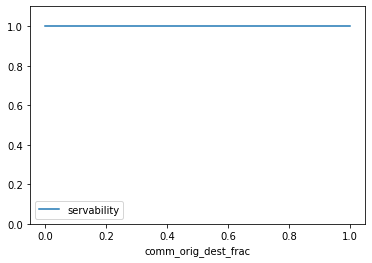

In [7]:
n_reqs = 10000
n_drt = 150

df[(df["reqs"] == n_reqs) & (df["drt"] == n_drt)].plot("comm_orig_dest_frac", "servability")

plt.ylim(0,1.1)
plt.show()

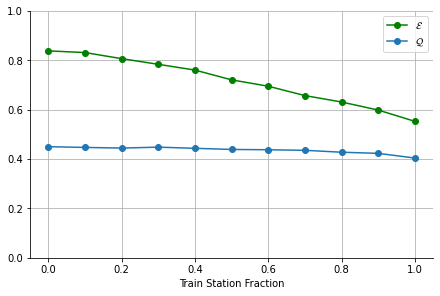

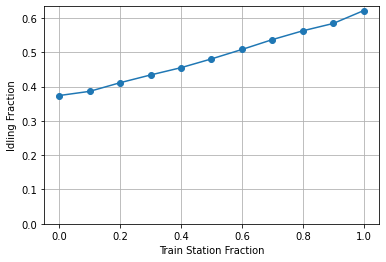

In [8]:
sub_df = df[(df["reqs"] == n_reqs) & (df["drt"] == n_drt)]

# fig, axes = plt.subplots(2,1,constrained_layout=True)
fig, ax = plt.subplots(constrained_layout=True)
# ax = axes[0]
ax.plot(sub_df["comm_orig_dest_frac"], 1/sub_df["unshared_dist_over_dist"], "-o", c="green", label="$\mathcal{E}$")#, sub_df["drt_travel_time_normalized"]-sub_df["drt_wait_time_normalized"])
# ax.plot(sub_df["comm_orig_dest_frac"], sub_df["b_over_delta"], "-o")
# ax.set_ylim(0,2)
# ax.grid()
# ax.axhline(1)
# ax.set_xlabel("Train Station Fraction")
# ax.set_ylabel(r"$\mathcal{E}$")
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)
# fig.savefig("figures/VaryOrigDestDiscreteEmissions.jpg", dpi=300)

# fig, ax = plt.subplots()
# ax = axes[1]
ax.plot(sub_df["comm_orig_dest_frac"], 1/sub_df["drt_travel_time_normalized"], "-o", label="$\mathcal{Q}$")
ax.grid()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Train Station Fraction")
# ax.set_ylabel(r"$\mathcal{Q}$")
ax.legend()
ax.set_ylim(0,1)
# fig.savefig("Figures/TrainStationFracUniform.pgf")

fig, ax = plt.subplots()
ax.plot(sub_df["comm_orig_dest_frac"], sub_df["idling_frac"], "-o")
ax.grid()
ax.set_ylim(0,None)
ax.set_xlabel("Train Station Fraction")
ax.set_ylabel("Idling Fraction")
# fig.savefig("Figures/VaryOrigDestDiscreteQuality.jpg", dpi=300)

plt.show()

In [16]:
Q = 1/sub_df["drt_travel_time_normalized"]
print(sub_df["comm_orig_dest_frac"])
print(Q/Q[9])

9     0.0
1     0.1
6     0.2
4     0.3
2     0.4
7     0.5
0     0.6
10    0.7
3     0.8
8     0.9
5     1.0
Name: comm_orig_dest_frac, dtype: float64
0.9501799092398017
0.9853875472043341
9     1.000000
1     0.993205
6     0.987625
4     0.995666
2     0.985388
7     0.975146
0     0.972366
10    0.967286
3     0.950180
8     0.939920
5     0.897699
Name: drt_travel_time_normalized, dtype: float64


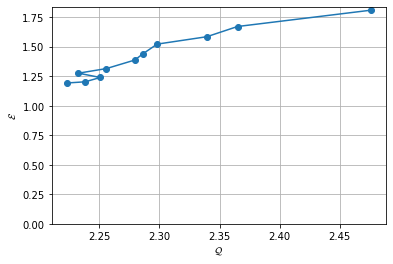

In [67]:
fig, ax = plt.subplots()
ax.plot(sub_df["drt_travel_time_normalized"], sub_df["unshared_dist_over_dist"], "-o")
ax.grid()
ax.set_ylim(0,None)
ax.set_xlabel("$\mathcal{Q}$")
ax.set_ylabel("$\mathcal{E}$")


plt.show()

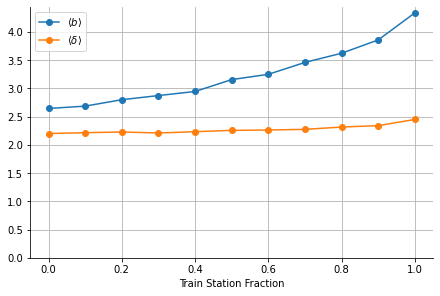

In [68]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(sub_df["comm_orig_dest_frac"], sub_df["occupancy_non_idling"], "-o", label=r"$\langle b\rangle$")
ax.plot(sub_df["comm_orig_dest_frac"], sub_df["detour"], "-o", label=r"$\langle\delta\rangle$")
ax.grid()
ax.legend()
ax.set_ylim(0,None)
ax.set_xlabel("Train Station Fraction")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# fig.savefig("Figures/CommOrigDestBDelta.pgf")

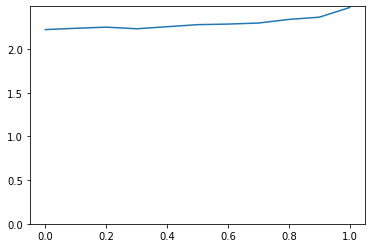

In [8]:
# plt.plot(sub_df["comm_orig_dest_frac"], sub_df["unshared_dist_over_dist"]/sub_df["b_over_delta"])
plt.plot(sub_df["comm_orig_dest_frac"], sub_df["drt_travel_time_normalized"])
plt.ylim(0,None)

plt.show()

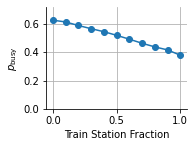

In [26]:
figsize = [x*0.4 for x in [6.4,4.8]]
fig, ax = plt.subplots(constrained_layout=True, figsize=figsize)

p_busy = 1-sub_df["idling_frac"]
ax.plot(sub_df["comm_orig_dest_frac"], p_busy, "-o")#, label=r"$p_\mathrm{busy}$")
ax.grid()
# ax.legend()
ax.set_ylim(0,p_busy.max()*1.15)
ax.set_xlabel("Train Station Fraction")
ax.set_ylabel(r"$p_\mathrm{busy}$")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# fig.savefig("Figures/CommOrigDestPBusy.pgf")